In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
from matplotlib import animation, rc
import numpy as np
from random import randint
from operator import *

from ipywidgets import widgets
from IPython.display import display

In [3]:
from flange.actions import *
from flange.combiners import *
from flange.conditions import *
from flange.graphs import *
from flange.locations import *
from flange.roots import *
from flange.runtime import *
from flange.utils import draw

%aimport flange.actions
%aimport flange.combiners
%aimport flange.conditions
%aimport flange.graphs
%aimport flange.locations
%aimport flange.roots
%aimport flange.runtime
%aimport flange.utils

In [4]:
def show(flanglet, graph, size=(8,10)):
    before = graph().copy()
    foci = flanglet.focus(before.copy())
    after = flanglet(before.copy())

    pos = nx.spring_layout(before)
    
    fig = plt.gcf()
    fig.set_figheight(size[0])
    fig.set_figwidth(size[1])
    
    cols = max(len(foci), 6)
    rows = 4
    ax_before = plt.subplot2grid((rows, cols), (0,0), colspan=cols//2, rowspan=3)
    ax_after = plt.subplot2grid((rows, cols), (0,cols//2), colspan=cols//2, rowspan=3)
        
    nx.draw(before, pos=pos, ax=ax_before)
    nx.draw_networkx_labels(before, pos=pos, ax=ax_before)

    for (i, sub) in enumerate(foci):
        ax_select = plt.subplot2grid((rows, cols), (3, i))
        nx.draw(sub, pos=pos, ax=ax_select)
        nx.draw_networkx_labels(sub, pos=pos, ax=ax_select)

    nx.draw(after, pos=pos, ax=ax_after)
    nx.draw_networkx_labels(after, pos=pos, ax=ax_after)
    
    return fig

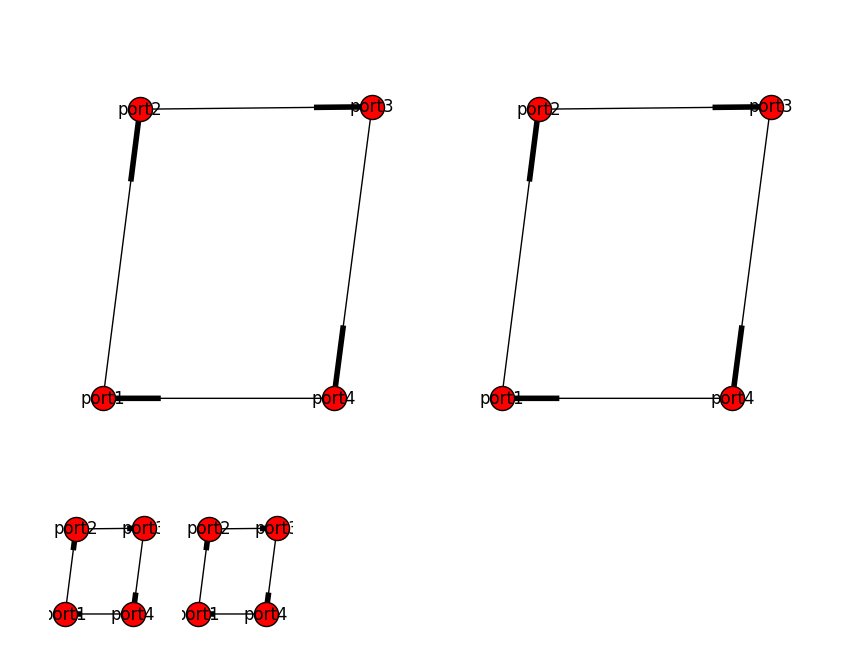

In [5]:
fig = show(rule(lambda x: x, lambda x:x), graph("ring"))

In [6]:
#assert place firewall on group A in G
#aasert place 10mb path between path(CREST MSU from G)

In [7]:
ab_ring = nx.DiGraph()
ab_ring.add_nodes_from(["A1", "A2", "A3", "A4", "A5", "B1", "B2", "B3"])
ab_ring.add_edges_from([("A1", "A2"), ("A2", "A3"), ("A3", "B1"), 
                        ("B1", "A4"), 
                        ("A4", "B2"), ("B2", "B3"), ("B3", "A5"),
                       ("A5", "A1")])

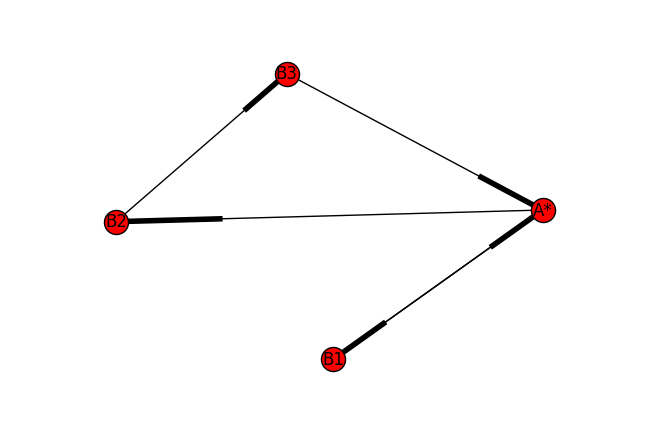

In [8]:
draw(collect(lambda g: [n for n in g.nodes() if n.startswith("A")], "A*")(ab_ring))

In [27]:
assure("firewall", collect(nodes() >> startswith("A")))(ab_ring)

TypeError: 'str' object is not callable

In [22]:
class startswith(FlangeTree):
    def __init__(self, val):
        self.val = val

    def __call__(self, names):
        return [name for name in names if name.startswith(self.val)] 

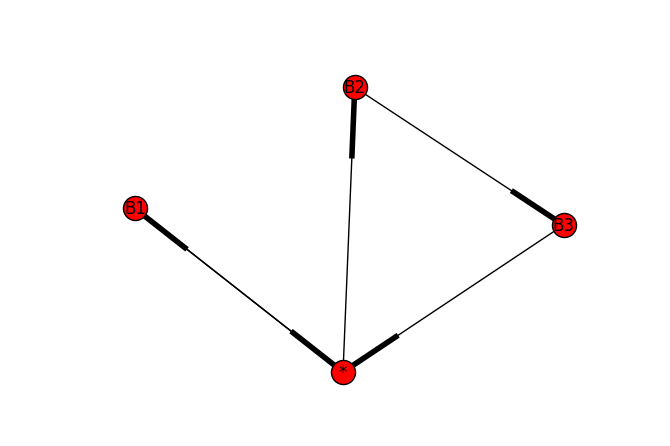

In [30]:
draw(collect(nodes() >> startswith("A"))(ab_ring))